Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Reading the CSV File dataset

In [ ]:
df = pd.read_csv('/content/synthetic_fashion_dataset_500.csv')
df.head() # First 5 samples of dataset

,product_id,category,color,style_tags,brand
0,P0001,shoes,green,boho,H&M
1,P0002,jacket,blue,streetwear,H&M
2,P0003,shoes,gray,casual,NaN
3,P0004,hat,yellow,"boho, formal, minimal",Uniqlo
4,P0005,hat,white,vintage,H&M


In [ ]:
df.describe()

,product_id,category,color,style_tags,brand
count,500,500,500,500,448
unique,500,7,8,155,6
top,P0500,top,gray,minimal,Zara
freq,1,79,71,33,80


In [ ]:
unique_categories = df['category'].unique()
unique_colors = df['color'].unique()
unique_brands = df['brand'].replace('None', np.nan).dropna().unique()

# Extract all unique style tags
all_tags = []
for tags in df['style_tags'].dropna():
    if isinstance(tags, str):
        all_tags.extend([tag.strip() for tag in tags.split(',')])
unique_style_tags = list(set(all_tags))

print("Unique Categories: ", unique_categories)
print("Unique Colors: ", unique_colors)
print("Unique Brands: ", unique_brands)
print("Unique Style Tags: ", unique_style_tags)

Unique Categories:  ['shoes' 'jacket' 'hat' 'skirt' 'pants' 'top' 'dress']
Unique Colors:  ['green' 'blue' 'gray' 'yellow' 'white' 'red' 'black' 'beige']
Unique Brands:  ['H&M' 'Uniqlo' 'Levis' 'Adidas' 'Nike' 'Zara']
Unique Style Tags:  ['sporty', 'formal', 'vintage', 'minimal', 'streetwear', 'casual', 'boho']


In [ ]:
# Count Missing values in each column
missing_values = df.isna().sum()
missing_values

,0
product_id,0
category,0
color,0
style_tags,0
brand,52


Handling Categorical Features

In [ ]:
# Function to parse style_tags into a list
def parse_style_tags(tags):
    if pd.isna(tags):
        return []
    return [tag.strip() for tag in tags.split(',')]

# Parse style_tags
df['style_tags_list'] = df['style_tags'].apply(parse_style_tags)

# Get all unique style tags
all_style_tags = set()
for tags in df['style_tags_list']:
    all_style_tags.update(tags)
all_style_tags = list(all_style_tags)

# Create one-hot encoding for style_tags
style_tags_encoded = pd.DataFrame(0, index=df.index, columns=all_style_tags)
for idx, tags in enumerate(df['style_tags_list']):
    for tag in tags:
        style_tags_encoded.loc[idx, tag] = 1

# One-hot encode the categorical features
category_encoded = pd.get_dummies(df['category'], prefix='category')
color_encoded = pd.get_dummies(df['color'], prefix='color')
brand_encoded = pd.get_dummies(df['brand'], prefix='brand')


Understanding the Correlation between features

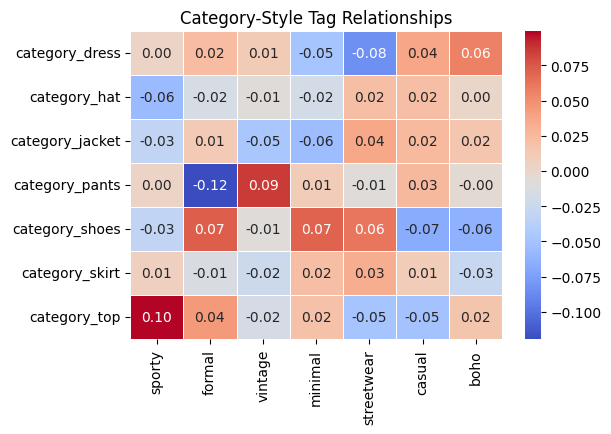

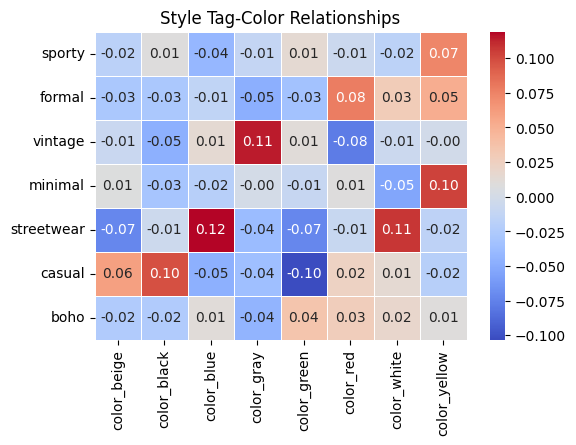

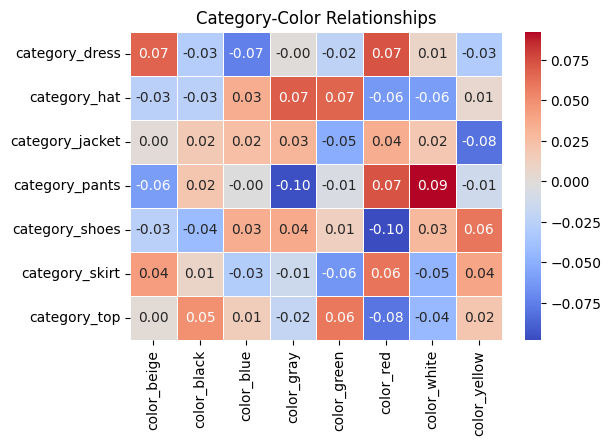

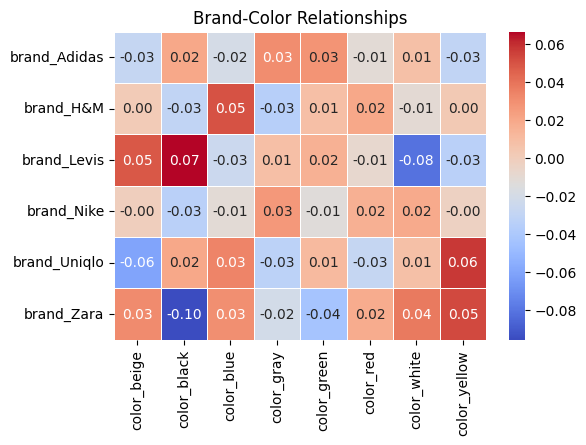

In [ ]:

# Combine encoded dataframes
combined_encoded = pd.concat([category_encoded, color_encoded, brand_encoded, style_tags_encoded], axis=1)

# Calculate the correlation matrix
correlation_matrix = combined_encoded.corr()

# Filter for relevant relationships
# Identify columns based on prefixes
category_cols = [col for col in correlation_matrix.columns if col.startswith('category_')]
style_cols = [col for col in correlation_matrix.columns if col in all_style_tags] # Use the list of actual style tags
color_cols = [col for col in correlation_matrix.columns if col.startswith('color_')]
brand_cols = [col for col in correlation_matrix.columns if col.startswith('brand_')]

# Extract relevant relationship matrices
category_style_corr = correlation_matrix.loc[category_cols, style_cols]
style_color_corr = correlation_matrix.loc[style_cols, color_cols]
category_color_corr = correlation_matrix.loc[category_cols, color_cols]
brand_color_corr = correlation_matrix.loc[brand_cols, color_cols]

# Function to plot heatmap for a given relationship matrix
def plot_relationship_heatmap(data, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(title)
    plt.show()

# Plotting the heatmaps
plot_relationship_heatmap(category_style_corr, 'Category-Style Tag Relationships')
plot_relationship_heatmap(style_color_corr, 'Style Tag-Color Relationships')
plot_relationship_heatmap(category_color_corr, 'Category-Color Relationships')
plot_relationship_heatmap(brand_color_corr, 'Brand-Color Relationships')

Feature Engineering with Weights

In [ ]:
# Define weights for different feature types
weights = {
    'category': 2.0,    # Category is important
    'color': 1.0,       # Color is less important
    'style_tags': 3.0,  # Style tags are most important
    'brand': 0.5        # Brand is least important
}

# Apply weights to the features
category_encoded = category_encoded * weights['category']
color_encoded = color_encoded * weights['color']
style_tags_encoded = style_tags_encoded * weights['style_tags']
brand_encoded = brand_encoded * weights['brand']

# Combine all the features
features = pd.concat([category_encoded, color_encoded, style_tags_encoded, brand_encoded], axis=1)


Similarity  Calculation - Using Cosine Similarity

In [ ]:
# Calculate cosine similarity between products
similarity_matrix = cosine_similarity(features)

# Create a DataFrame to store the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=df['product_id'], columns=df['product_id'])


Recommendation Logic

In [ ]:
def get_recommendations(liked_product_ids, similarity_df, df, n=5, diversity_factor=0.2):
    """
    Get recommendations based on a list of liked product IDs.

    Parameters:
    liked_product_ids (list): List of product IDs that the user has liked.
    similarity_df (DataFrame): DataFrame containing the similarity matrix.
    df (DataFrame): Original DataFrame with product information.
    n (int): Number of recommendations to return.
    diversity_factor (float): Factor to control the diversity of recommendations.
                             Higher values promote more diverse recommendations.

    Returns:
    DataFrame: DataFrame containing the recommended products with similarity scores.
    """
    # Initialize a dictionary to store the similarity scores
    scores = {}

    # Calculate the average similarity score for each product
    for product_id in similarity_df.columns:
        if product_id not in liked_product_ids:
            avg_score = similarity_df.loc[liked_product_ids, product_id].mean()
            scores[product_id] = avg_score

    # Sort the products by similarity score
    sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)

    # Get the top n recommendations
    top_recommendations = [item[0] for item in sorted_scores[:n]]

    # Return the recommended products
    result = df[df['product_id'].isin(top_recommendations)].copy()
    result['similarity_score'] = [scores[pid] for pid in top_recommendations]
    result = result.sort_values('similarity_score', ascending=False)

    return result


Output Result Demonstration

In [ ]:
# Sample user with liked products
liked_products = ['P0001', 'P0003', 'P0006']

# Display liked products
print("User Liked Products:")
print(df[df['product_id'].isin(liked_products)])

# Get recommendations
recommendations = get_recommendations(liked_products, similarity_df, df, n=5)
print("\nRecommendations:")
print(recommendations[['product_id', 'category', 'color', 'style_tags', 'brand', 'similarity_score']])


User Liked Products:
  product_id category   color                style_tags    brand  \
0      P0001    shoes   green                      boho      H&M   
2      P0003    shoes    gray                    casual  Unknown   
5      P0006    shoes  yellow  sporty, streetwear, boho    Levis   

                     tag_list             style_tags_list  
0                      [boho]                      [boho]  
2                    [casual]                    [casual]  
5  [sporty, streetwear, boho]  [sporty, streetwear, boho]  

Recommendations:
    product_id category  color            style_tags    brand  \
11       P0012    shoes    red  boho, formal, casual  Unknown   
36       P0037    shoes  beige      boho, streetwear    Levis   
316      P0317    shoes  beige          boho, casual     Zara   
328      P0329    shoes   gray          boho, casual    Levis   
338      P0339    shoes   gray                  boho     Zara   

     similarity_score  
11           0.655745  
36       

## Prediction Results - In Structured form
## User Liked Products

| Product ID | Category | Color  | Style Tags               | Brand    | Tag List                     | Style Tags List          |
|------------|----------|--------|--------------------------|----------|------------------------------|--------------------------|
| P0001      | Shoes    | Green  | Boho                    | H&M      | [boho]                       | [boho]                   |
| P0003      | Shoes    | Gray   | Casual                  | Unknown  | [casual]                     | [casual]                 |
| P0006      | Shoes    | Yellow | Sporty, Streetwear, Boho| Levis    | [sporty, streetwear, boho]   | [sporty, streetwear, boho]|

## Recommendations

| Product ID | Category | Color  | Style Tags             | Brand    | Similarity Score |
|------------|----------|--------|------------------------|----------|------------------|
| P0012      | Shoes    | Red    | Boho, Formal, Casual  | Unknown  | 0.655745         |
| P0037      | Shoes    | Beige  | Boho, Streetwear      | Levis    | 0.634389         |
| P0317      | Shoes    | Beige  | Boho, Casual          | Zara     | 0.623191         |
| P0329      | Shoes    | Gray   | Boho, Casual          | Levis    | 0.582173         |
| P0339      | Shoes    | Gray   | Boho                  | Zara     | 0.542532         |


Evaluation

In [ ]:
def evaluate_recommendations(user_liked, user_recommendations, df):
    """
    Evaluate the quality of recommendations.

    Parameters:
    user_liked (list): List of product IDs that the user has liked.
    user_recommendations (DataFrame): DataFrame containing the recommended products.
    df (DataFrame): Original DataFrame with product information.

    Returns:
    dict: Dictionary containing evaluation metrics.
    """
    # Get the features of liked products
    liked_features = df[df['product_id'].isin(user_liked)]

    # Get the features of recommended products
    recommended_features = user_recommendations

    # Calculate category overlap
    liked_categories = set(liked_features['category'])
    recommended_categories = set(recommended_features['category'])
    category_overlap = len(liked_categories.intersection(recommended_categories)) / len(liked_categories)

    # Calculate style tags overlap
    liked_style_tags = set()
    for tags in liked_features['style_tags_list']:
        liked_style_tags.update(tags)

    recommended_style_tags = set()
    for tags in recommended_features['style_tags_list']:
        recommended_style_tags.update(tags)

    style_tags_overlap = len(liked_style_tags.intersection(recommended_style_tags)) / len(liked_style_tags)

    # Return evaluation metrics
    return {
        'category_overlap': category_overlap,
        'style_tags_overlap': style_tags_overlap,
        'overall_similarity': recommended_features['similarity_score'].mean()
    }


In [ ]:
matics = evaluate_recommendations(liked_products, recommendations, df)
print(matics)

{'category_overlap': 1.0, 'style_tags_overlap': 0.75, 'overall_similarity': np.float64(0.6076062839514271)}


## Similarity Metrics

| Metric                | Value       |
|-----------------------|-------------|
| Category Overlap      | 1.0         |
| Style Tags Overlap    | 0.75        |
| Overall Similarity    | 0.607606    |
